In [1]:
import torch
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

from torch.optim import lr_scheduler
from torch.autograd import Variable


NUM_CAPS = 16
NUM_FILTERS_CONV1 = 128
CONV1_SIZE = 7
CONV2_SIZE = 7
NUM_FILTERS_CONV2 = 256
IMG_DIM = 64
IMG_CH = 3
POOL_SIZE = 2
POOL_STRIDE = 2
CAPS_SIZE = 8
CLASS_REPR = 8 # number of nodes representing one class

def squash(x):
    lengths2 = x.pow(2).sum(dim=2)
    lengths = lengths2.sqrt()
    x = x * (lengths2 / (1 + lengths2) / lengths).view(x.size(0), x.size(1), 1)
    return x


class AgreementRouting(nn.Module):
    def __init__(self, input_caps, output_caps, n_iterations):
        super(AgreementRouting, self).__init__()
        self.n_iterations = n_iterations
        self.b = nn.Parameter(torch.zeros((input_caps, output_caps)))

    def forward(self, u_predict):
        batch_size, input_caps, output_caps, output_dim = u_predict.size()
        
        c = F.softmax(self.b)
        s = (c.unsqueeze(2) * u_predict).sum(dim=1)
        v = squash(s)

        if self.n_iterations > 0:
            b_batch = self.b.expand((batch_size, input_caps, output_caps))
            for r in range(self.n_iterations):
                v = v.unsqueeze(1)
                b_batch = b_batch + (u_predict * v).sum(-1)

                c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)
                s = (c * u_predict).sum(dim=1)
                v = squash(s)

        return v


class CapsLayer(nn.Module):
    def __init__(self, input_caps, input_dim, output_caps, output_dim, routing_module):
        super(CapsLayer, self).__init__()
        self.input_dim = input_dim
        self.input_caps = input_caps
        self.output_dim = output_dim
        self.output_caps = output_caps
        self.weights = nn.Parameter(torch.Tensor(input_caps, input_dim, output_caps * output_dim))
        self.routing_module = routing_module
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.input_caps)
        self.weights.data.uniform_(-stdv, stdv)

    def forward(self, caps_output):
        caps_output = caps_output.unsqueeze(2)
        u_predict = caps_output.matmul(self.weights)
        u_predict = u_predict.view(u_predict.size(0), self.input_caps, self.output_caps, self.output_dim)
        v = self.routing_module(u_predict)
        return v


class PrimaryCapsLayer(nn.Module):
    def __init__(self, input_channels, output_caps, output_dim, kernel_size, stride):
        super(PrimaryCapsLayer, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_caps * output_dim, kernel_size=kernel_size, stride=stride)
        self.input_channels = input_channels
        self.output_caps = output_caps
        self.output_dim = output_dim

    def forward(self, input):
        out = self.conv(input)
        N, C, H, W = out.size()
        out = out.view(N, self.output_caps, self.output_dim, H, W)

        # will output N x OUT_CAPS x OUT_DIM
        out = out.permute(0, 1, 3, 4, 2).contiguous()
        out = out.view(out.size(0), -1, out.size(4))
        out = squash(out)
        return out


class CapsNet(nn.Module):
    def __init__(self, routing_iterations, n_classes=200):
        super(CapsNet, self).__init__()
        # N = batch

        self.conv1 = nn.Conv2d(IMG_CH, NUM_FILTERS_CONV1, kernel_size=CONV1_SIZE, stride=1)
        self.pool1 = nn.MaxPool2d(POOL_SIZE, stride=POOL_STRIDE)
        self.conv2 = nn.Conv2d(NUM_FILTERS_CONV1, NUM_FILTERS_CONV2, kernel_size=CONV2_SIZE, stride=1)
        self.primaryCaps = PrimaryCapsLayer(NUM_FILTERS_CONV2, NUM_CAPS, CAPS_SIZE, kernel_size=9, stride=2)  # outputs 6*6
        
        self.num_primaryCaps = NUM_CAPS * 6 * 6
        routing_module = AgreementRouting(self.num_primaryCaps, n_classes, routing_iterations)
        self.digitCaps = CapsLayer(self.num_primaryCaps, CAPS_SIZE, n_classes, CLASS_REPR, routing_module)

    def forward(self, input):
        x = input.permute(0, 3, 1, 2)
        x = self.pool1(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.primaryCaps(x)
        x = self.digitCaps(x)
        probs = x.pow(2).sum(dim=2).sqrt()
        return x, probs


class ReconstructionNet(nn.Module):
    def __init__(self, n_dim=8, n_classes=200):
        super(ReconstructionNet, self).__init__()
        self.fc1 = nn.Linear(n_dim * n_classes, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 784)
        self.n_dim = n_dim
        self.n_classes = n_classes

    def forward(self, x, target):
        mask = Variable(torch.zeros((x.size()[0], self.n_classes)), requires_grad=False)
        if next(self.parameters()).is_cuda:
            mask = mask.cuda()
        mask.scatter_(1, target.view(-1, 1), 1.)
        mask = mask.unsqueeze(2)
        x = x * mask
        x = x.view(-1, self.n_dim * self.n_classes)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x


class CapsNetWithReconstruction(nn.Module):
    def __init__(self, capsnet, reconstruction_net):
        super(CapsNetWithReconstruction, self).__init__()
        self.capsnet = capsnet
        self.reconstruction_net = reconstruction_net

    def forward(self, x, target):
        x, probs = self.capsnet(x)
        reconstruction = self.reconstruction_net(x, target)
        return reconstruction, probs


class MarginLoss(nn.Module):
    def __init__(self, m_pos, m_neg, lambda_):
        super(MarginLoss, self).__init__()
        self.m_pos = m_pos
        self.m_neg = m_neg
        self.lambda_ = lambda_

    def forward(self, lengths, targets, size_average=True):
        t = torch.zeros(lengths.size()).long()
        if targets.is_cuda:
            t = t.cuda()
        t = t.scatter_(1, targets.data.view(-1, 1), 1)
        targets = Variable(t)
        losses = targets.float() * F.relu(self.m_pos - lengths).pow(2) + \
                 self.lambda_ * (1. - targets.float()) * F.relu(lengths - self.m_neg).pow(2)
        return losses.mean() if size_average else losses.sum()


In [3]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader
import os
from scipy.misc import imread
import numpy as np
import torch

ROOT = '/datasets/Tiny-ImageNet/tiny-imagenet-200'


"""
Define dataset
"""
class tinetDataset(Dataset):
    def __init__(self, dataroot, datapaths, labels, training=False):
        self.dataroot = dataroot
        self.training = training
        self.datapaths = datapaths
        self.labels = labels
        
    def __len__(self):
        return len(self.datapaths)
    
    def __getitem__(self, idx):
        img = imread(self.dataroot + self.datapaths[idx])
        if img.shape == (IMG_DIM, IMG_DIM):
            img = np.stack((img,)*3, axis=-1)
        return torch.from_numpy(np.asarray(img.flatten())).view(IMG_DIM, IMG_DIM, IMG_CH).type(torch.FloatTensor), torch.from_numpy(np.asarray(self.labels[idx].flatten())).type(torch.LongTensor)

# # Training settings
# parser = argparse.ArgumentParser(description='CapsNet with MNIST')
# parser.add_argument('--batch-size', type=int, default=128, metavar='N',
#                     help='input batch size for training (default: 64)')
# parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
#                     help='input batch size for testing (default: 1000)')
# parser.add_argument('--epochs', type=int, default=250, metavar='N',
#                     help='number of epochs to train (default: 10)')
# parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
#                     help='learning rate (default: 0.01)')
# parser.add_argument('--no-cuda', action='store_true', default=False,
#                     help='disables CUDA training')
# parser.add_argument('--seed', type=int, default=1, metavar='S',
#                     help='random seed (default: 1)')
# parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                     help='how many batches to wait before logging training status')
# parser.add_argument('--routing_iterations', type=int, default=3)
# parser.add_argument('--with_reconstruction', action='store_true', default=False)
# args = parser.parse_args()
# args.cuda = not args.no_cuda and torch.cuda.is_available()


BATCH_SIZE = 50
TEST_BATCH_SIZE = 50
EPOCHS = 20
LEARNING_RATE = 0.002
CUDA = torch.cuda.is_available()
SEED = 1
LOG_INT = 10 # how many batches to wait before logging training status
ROUTING_ITERS = 3
RECONSTRUCTION = False

NUMSTATSPEREPOCH = 2

kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

In [4]:
# create training and val set
labels = next(os.walk(ROOT + '/train'))[1]
label_id = dict(zip(labels, range(len(labels))))

# generate the training set and labels
train_labels = np.zeros((200*500))
train_datapaths = [''] * (200*500)

counter = 0
for label in labels:
    curr_dir = ROOT + '/train'
    img_subdir = '/' + label + '/images/'
    images = os.listdir(curr_dir + img_subdir)
    for image in images:
        train_datapaths[counter] = img_subdir + image
        train_labels[counter] = label_id[label]
        counter += 1
        
# get the validation set and labels
val_labels = np.zeros((200*50))
val_datapaths = [''] * (200*50)

curr_dir = ROOT + '/val'
val_info = np.genfromtxt(curr_dir + '/val_annotations.txt', delimiter='\t', dtype=None)
counter = 0

images = []

for info in val_info:
    val_datapaths[counter] = '/images/' + info[0]
    val_labels[counter] = label_id[info[1]]
    counter += 1

In [5]:
# define training and validation data loaders    
    
train_loader = torch.utils.data.DataLoader(
    tinetDataset(ROOT + '/train', train_datapaths, train_labels, training = True),
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    tinetDataset(ROOT + '/val', val_datapaths, val_labels, training = False),
    batch_size=TEST_BATCH_SIZE, shuffle=False)

model = CapsNet(ROUTING_ITERS)

if RECONSTRUCTION:
    reconstruction_model = ReconstructionNet(8, 200)
    reconstruction_alpha = 0.0005
    model = CapsNetWithReconstruction(model, reconstruction_model)

if CUDA:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=2, min_lr=1e-6)

loss_fn = MarginLoss(0.9, 0.1, 0.5)

In [6]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target, requires_grad=False)
        optimizer.zero_grad()
        if RECONSTRUCTION:
            output, probs = model(data, target)
            reconstruction_loss = F.mse_loss(output, data.view(-1, 784))
            margin_loss = loss_fn(probs, target)
            loss = reconstruction_alpha * reconstruction_loss + margin_loss
        else:
            output, probs = model(data)
            loss = loss_fn(probs, target)
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INT == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.data[0]))

def train(Epoch,Loss,numStatsPerEpoch,Rec_loss_every=1):
    model.train()
    statIdx = [len(train_loader)/numStatsPerEpoch]*numStatsPerEpoch
    statIdx = [(i)*a for i,a in enumerate(statIdx)]
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # get stats
        if (batch_idx) in statIdx:
            test_loss, test_acc,TN,TD = getLossAccND('Test',test_loader)
            print
            TestLoss.append(test_loss);TestAcc.append(test_acc);
    
        # train
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target, requires_grad=False)
        optimizer.zero_grad()
        if RECONSTRUCTION:
            output, probs = model(data, target)
            reconstruction_loss = F.mse_loss(output, data.view(-1, 784))
            margin_loss = loss_fn(probs, target)
            loss = reconstruction_alpha * reconstruction_loss + margin_loss
        else:
            output, probs = model(data)
            loss = loss_fn(probs, target)
        
        if batch_idx % Rec_loss_every == 0:
            Loss.append(loss.data[0])
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INT == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                Epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.data[0]))
def getLossAccND(name,dataloader):
    model.eval()
    loss = 0
    correct = 0
    for data, target in dataloader:
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        #print data, target
        if RECONSTRUCTION:
            output, probs = model(data, target)
            reconstruction_loss = F.mse_loss(output, data.view(-1, 784), size_average=False).data[0]
            loss += loss_fn(probs, target, size_average=False).data[0]
            loss += reconstruction_alpha * reconstruction_loss
        else:
            output, probs = model(data)
            loss += loss_fn(probs, target, size_average=False).data[0]

        pred = probs.data.max(1, keepdim=True)[1]  # get the index of the max probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss /= len(dataloader.dataset)
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name,loss, correct, len(dataloader.dataset),
        100. * correct / len(dataloader.dataset)))
    return (loss, 100. * correct / len(dataloader.dataset), correct, len(dataloader.dataset))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)

        if RECONSTRUCTION:
            output, probs = model(data, target)
            reconstruction_loss = F.mse_loss(output, data.view(-1, 784), size_average=False).data[0]
            test_loss += loss_fn(probs, target, size_average=False).data[0]
            test_loss += reconstruction_alpha * reconstruction_loss
        else:
            output, probs = model(data)
            test_loss += loss_fn(probs, target, size_average=False).data[0]

        pred = probs.data.max(1, keepdim=True)[1]  # get the index of the max probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss


TrainLoss = []; TrainL_every = 1; TrN=0; TrD=0
TestLoss = []; TestAcc = []; TN=0; TD=0
for epoch in range(1, EPOCHS + 1):
    train(epoch,TrainLoss,NUMSTATSPEREPOCH,TrainL_every)
    scheduler.step(TestLoss[-1])
    #torch.save(model,'timagenetFINAL.pth')

# get final training and testing stats
ftest_loss, ftest_acc,TN,TD = getLossAccND('Test',test_loader)
ftrain_loss, ftrain_acc,TrN,TrD = getLossAccND('Train',train_loader)


Test set: Average loss: 0.8099, Accuracy: 53/10000 (1%)


Train Epoch: 1 [0/100000 (0%)]	Loss: 0.004049
Train Epoch: 1 [500/100000 (0%)]	Loss: 0.004049
Train Epoch: 1 [1000/100000 (1%)]	Loss: 0.004049
Train Epoch: 1 [1500/100000 (2%)]	Loss: 0.004047
Train Epoch: 1 [2000/100000 (2%)]	Loss: 0.004044
Train Epoch: 1 [2500/100000 (2%)]	Loss: 0.004035
Train Epoch: 1 [3000/100000 (3%)]	Loss: 0.004026
Train Epoch: 1 [3500/100000 (4%)]	Loss: 0.003984
Train Epoch: 1 [4000/100000 (4%)]	Loss: 0.003928
Train Epoch: 1 [4500/100000 (4%)]	Loss: 0.003800
Train Epoch: 1 [5000/100000 (5%)]	Loss: 0.003604
Train Epoch: 1 [5500/100000 (6%)]	Loss: 0.003472
Train Epoch: 1 [6000/100000 (6%)]	Loss: 0.003292
Train Epoch: 1 [6500/100000 (6%)]	Loss: 0.003285
Train Epoch: 1 [7000/100000 (7%)]	Loss: 0.003258
Train Epoch: 1 [7500/100000 (8%)]	Loss: 0.003217
Train Epoch: 1 [8000/100000 (8%)]	Loss: 0.003215
Train Epoch: 1 [8500/100000 (8%)]	Loss: 0.003219
Train Epoch: 1 [9000/100000 (9%)]	Loss: 0.003222
Train Epoch: 1

Train Epoch: 1 [80000/100000 (80%)]	Loss: 0.003221
Train Epoch: 1 [80500/100000 (80%)]	Loss: 0.003101
Train Epoch: 1 [81000/100000 (81%)]	Loss: 0.003232
Train Epoch: 1 [81500/100000 (82%)]	Loss: 0.003089
Train Epoch: 1 [82000/100000 (82%)]	Loss: 0.003167
Train Epoch: 1 [82500/100000 (82%)]	Loss: 0.003158
Train Epoch: 1 [83000/100000 (83%)]	Loss: 0.003155
Train Epoch: 1 [83500/100000 (84%)]	Loss: 0.003145
Train Epoch: 1 [84000/100000 (84%)]	Loss: 0.003127
Train Epoch: 1 [84500/100000 (84%)]	Loss: 0.003179
Train Epoch: 1 [85000/100000 (85%)]	Loss: 0.003149
Train Epoch: 1 [85500/100000 (86%)]	Loss: 0.003152
Train Epoch: 1 [86000/100000 (86%)]	Loss: 0.003161
Train Epoch: 1 [86500/100000 (86%)]	Loss: 0.003140
Train Epoch: 1 [87000/100000 (87%)]	Loss: 0.003168
Train Epoch: 1 [87500/100000 (88%)]	Loss: 0.003139
Train Epoch: 1 [88000/100000 (88%)]	Loss: 0.003111
Train Epoch: 1 [88500/100000 (88%)]	Loss: 0.003116
Train Epoch: 1 [89000/100000 (89%)]	Loss: 0.003181
Train Epoch: 1 [89500/100000 (9

Train Epoch: 2 [60000/100000 (60%)]	Loss: 0.003118
Train Epoch: 2 [60500/100000 (60%)]	Loss: 0.003079
Train Epoch: 2 [61000/100000 (61%)]	Loss: 0.003160
Train Epoch: 2 [61500/100000 (62%)]	Loss: 0.003069
Train Epoch: 2 [62000/100000 (62%)]	Loss: 0.003064
Train Epoch: 2 [62500/100000 (62%)]	Loss: 0.003075
Train Epoch: 2 [63000/100000 (63%)]	Loss: 0.003209
Train Epoch: 2 [63500/100000 (64%)]	Loss: 0.003081
Train Epoch: 2 [64000/100000 (64%)]	Loss: 0.003108
Train Epoch: 2 [64500/100000 (64%)]	Loss: 0.003090
Train Epoch: 2 [65000/100000 (65%)]	Loss: 0.003059
Train Epoch: 2 [65500/100000 (66%)]	Loss: 0.003096
Train Epoch: 2 [66000/100000 (66%)]	Loss: 0.003175
Train Epoch: 2 [66500/100000 (66%)]	Loss: 0.003084
Train Epoch: 2 [67000/100000 (67%)]	Loss: 0.003102
Train Epoch: 2 [67500/100000 (68%)]	Loss: 0.003102
Train Epoch: 2 [68000/100000 (68%)]	Loss: 0.003075
Train Epoch: 2 [68500/100000 (68%)]	Loss: 0.003238
Train Epoch: 2 [69000/100000 (69%)]	Loss: 0.003062
Train Epoch: 2 [69500/100000 (7

Train Epoch: 3 [40500/100000 (40%)]	Loss: 0.003096
Train Epoch: 3 [41000/100000 (41%)]	Loss: 0.003001
Train Epoch: 3 [41500/100000 (42%)]	Loss: 0.003054
Train Epoch: 3 [42000/100000 (42%)]	Loss: 0.003092
Train Epoch: 3 [42500/100000 (42%)]	Loss: 0.003091
Train Epoch: 3 [43000/100000 (43%)]	Loss: 0.003084
Train Epoch: 3 [43500/100000 (44%)]	Loss: 0.003064
Train Epoch: 3 [44000/100000 (44%)]	Loss: 0.003027
Train Epoch: 3 [44500/100000 (44%)]	Loss: 0.003085
Train Epoch: 3 [45000/100000 (45%)]	Loss: 0.003000
Train Epoch: 3 [45500/100000 (46%)]	Loss: 0.003044
Train Epoch: 3 [46000/100000 (46%)]	Loss: 0.003050
Train Epoch: 3 [46500/100000 (46%)]	Loss: 0.002961
Train Epoch: 3 [47000/100000 (47%)]	Loss: 0.003025
Train Epoch: 3 [47500/100000 (48%)]	Loss: 0.003060
Train Epoch: 3 [48000/100000 (48%)]	Loss: 0.003153
Train Epoch: 3 [48500/100000 (48%)]	Loss: 0.003112
Train Epoch: 3 [49000/100000 (49%)]	Loss: 0.003041
Train Epoch: 3 [49500/100000 (50%)]	Loss: 0.003044

Test set: Average loss: 0.6132

Train Epoch: 4 [20500/100000 (20%)]	Loss: 0.002836
Train Epoch: 4 [21000/100000 (21%)]	Loss: 0.002938
Train Epoch: 4 [21500/100000 (22%)]	Loss: 0.003049
Train Epoch: 4 [22000/100000 (22%)]	Loss: 0.003087
Train Epoch: 4 [22500/100000 (22%)]	Loss: 0.003099
Train Epoch: 4 [23000/100000 (23%)]	Loss: 0.002996
Train Epoch: 4 [23500/100000 (24%)]	Loss: 0.003056
Train Epoch: 4 [24000/100000 (24%)]	Loss: 0.003006
Train Epoch: 4 [24500/100000 (24%)]	Loss: 0.003069
Train Epoch: 4 [25000/100000 (25%)]	Loss: 0.002954
Train Epoch: 4 [25500/100000 (26%)]	Loss: 0.002995
Train Epoch: 4 [26000/100000 (26%)]	Loss: 0.002999
Train Epoch: 4 [26500/100000 (26%)]	Loss: 0.003150
Train Epoch: 4 [27000/100000 (27%)]	Loss: 0.003053
Train Epoch: 4 [27500/100000 (28%)]	Loss: 0.003126
Train Epoch: 4 [28000/100000 (28%)]	Loss: 0.003019
Train Epoch: 4 [28500/100000 (28%)]	Loss: 0.003053
Train Epoch: 4 [29000/100000 (29%)]	Loss: 0.003053
Train Epoch: 4 [29500/100000 (30%)]	Loss: 0.003080
Train Epoch: 4 [30000/100000 (3

Train Epoch: 5 [0/100000 (0%)]	Loss: 0.002971
Train Epoch: 5 [500/100000 (0%)]	Loss: 0.002879
Train Epoch: 5 [1000/100000 (1%)]	Loss: 0.002905
Train Epoch: 5 [1500/100000 (2%)]	Loss: 0.003018
Train Epoch: 5 [2000/100000 (2%)]	Loss: 0.002948
Train Epoch: 5 [2500/100000 (2%)]	Loss: 0.002923
Train Epoch: 5 [3000/100000 (3%)]	Loss: 0.002998
Train Epoch: 5 [3500/100000 (4%)]	Loss: 0.002955
Train Epoch: 5 [4000/100000 (4%)]	Loss: 0.002982
Train Epoch: 5 [4500/100000 (4%)]	Loss: 0.003004
Train Epoch: 5 [5000/100000 (5%)]	Loss: 0.002984
Train Epoch: 5 [5500/100000 (6%)]	Loss: 0.002997
Train Epoch: 5 [6000/100000 (6%)]	Loss: 0.002822
Train Epoch: 5 [6500/100000 (6%)]	Loss: 0.002914
Train Epoch: 5 [7000/100000 (7%)]	Loss: 0.002974
Train Epoch: 5 [7500/100000 (8%)]	Loss: 0.002863
Train Epoch: 5 [8000/100000 (8%)]	Loss: 0.002931
Train Epoch: 5 [8500/100000 (8%)]	Loss: 0.002909
Train Epoch: 5 [9000/100000 (9%)]	Loss: 0.002884
Train Epoch: 5 [9500/100000 (10%)]	Loss: 0.002990
Train Epoch: 5 [10000/1

Train Epoch: 5 [80500/100000 (80%)]	Loss: 0.002970
Train Epoch: 5 [81000/100000 (81%)]	Loss: 0.002858
Train Epoch: 5 [81500/100000 (82%)]	Loss: 0.003031
Train Epoch: 5 [82000/100000 (82%)]	Loss: 0.002905
Train Epoch: 5 [82500/100000 (82%)]	Loss: 0.002783
Train Epoch: 5 [83000/100000 (83%)]	Loss: 0.003125
Train Epoch: 5 [83500/100000 (84%)]	Loss: 0.002747
Train Epoch: 5 [84000/100000 (84%)]	Loss: 0.002995
Train Epoch: 5 [84500/100000 (84%)]	Loss: 0.002925
Train Epoch: 5 [85000/100000 (85%)]	Loss: 0.003010
Train Epoch: 5 [85500/100000 (86%)]	Loss: 0.002854
Train Epoch: 5 [86000/100000 (86%)]	Loss: 0.002927
Train Epoch: 5 [86500/100000 (86%)]	Loss: 0.002952
Train Epoch: 5 [87000/100000 (87%)]	Loss: 0.002918
Train Epoch: 5 [87500/100000 (88%)]	Loss: 0.002936
Train Epoch: 5 [88000/100000 (88%)]	Loss: 0.002792
Train Epoch: 5 [88500/100000 (88%)]	Loss: 0.002915
Train Epoch: 5 [89000/100000 (89%)]	Loss: 0.002918
Train Epoch: 5 [89500/100000 (90%)]	Loss: 0.003050
Train Epoch: 5 [90000/100000 (9

Train Epoch: 6 [60500/100000 (60%)]	Loss: 0.002893
Train Epoch: 6 [61000/100000 (61%)]	Loss: 0.002815
Train Epoch: 6 [61500/100000 (62%)]	Loss: 0.003026
Train Epoch: 6 [62000/100000 (62%)]	Loss: 0.002807
Train Epoch: 6 [62500/100000 (62%)]	Loss: 0.002964
Train Epoch: 6 [63000/100000 (63%)]	Loss: 0.002770
Train Epoch: 6 [63500/100000 (64%)]	Loss: 0.002786
Train Epoch: 6 [64000/100000 (64%)]	Loss: 0.002978
Train Epoch: 6 [64500/100000 (64%)]	Loss: 0.002791
Train Epoch: 6 [65000/100000 (65%)]	Loss: 0.002932
Train Epoch: 6 [65500/100000 (66%)]	Loss: 0.002868
Train Epoch: 6 [66000/100000 (66%)]	Loss: 0.003008
Train Epoch: 6 [66500/100000 (66%)]	Loss: 0.002825
Train Epoch: 6 [67000/100000 (67%)]	Loss: 0.002933
Train Epoch: 6 [67500/100000 (68%)]	Loss: 0.002969
Train Epoch: 6 [68000/100000 (68%)]	Loss: 0.002971
Train Epoch: 6 [68500/100000 (68%)]	Loss: 0.002871
Train Epoch: 6 [69000/100000 (69%)]	Loss: 0.002879
Train Epoch: 6 [69500/100000 (70%)]	Loss: 0.002864
Train Epoch: 6 [70000/100000 (7

Train Epoch: 7 [41000/100000 (41%)]	Loss: 0.002805
Train Epoch: 7 [41500/100000 (42%)]	Loss: 0.002863
Train Epoch: 7 [42000/100000 (42%)]	Loss: 0.002716
Train Epoch: 7 [42500/100000 (42%)]	Loss: 0.002795
Train Epoch: 7 [43000/100000 (43%)]	Loss: 0.002745
Train Epoch: 7 [43500/100000 (44%)]	Loss: 0.002649
Train Epoch: 7 [44000/100000 (44%)]	Loss: 0.002917
Train Epoch: 7 [44500/100000 (44%)]	Loss: 0.002605
Train Epoch: 7 [45000/100000 (45%)]	Loss: 0.002764
Train Epoch: 7 [45500/100000 (46%)]	Loss: 0.002995
Train Epoch: 7 [46000/100000 (46%)]	Loss: 0.002505
Train Epoch: 7 [46500/100000 (46%)]	Loss: 0.002976
Train Epoch: 7 [47000/100000 (47%)]	Loss: 0.002774
Train Epoch: 7 [47500/100000 (48%)]	Loss: 0.002912
Train Epoch: 7 [48000/100000 (48%)]	Loss: 0.002852
Train Epoch: 7 [48500/100000 (48%)]	Loss: 0.002912
Train Epoch: 7 [49000/100000 (49%)]	Loss: 0.002860
Train Epoch: 7 [49500/100000 (50%)]	Loss: 0.002852

Test set: Average loss: 0.5900, Accuracy: 1560/10000 (16%)


Train Epoch: 7 [5000

Train Epoch: 8 [21000/100000 (21%)]	Loss: 0.002583
Train Epoch: 8 [21500/100000 (22%)]	Loss: 0.002711
Train Epoch: 8 [22000/100000 (22%)]	Loss: 0.002737
Train Epoch: 8 [22500/100000 (22%)]	Loss: 0.002777
Train Epoch: 8 [23000/100000 (23%)]	Loss: 0.003076
Train Epoch: 8 [23500/100000 (24%)]	Loss: 0.002673
Train Epoch: 8 [24000/100000 (24%)]	Loss: 0.002785
Train Epoch: 8 [24500/100000 (24%)]	Loss: 0.002534
Train Epoch: 8 [25000/100000 (25%)]	Loss: 0.002628
Train Epoch: 8 [25500/100000 (26%)]	Loss: 0.002558
Train Epoch: 8 [26000/100000 (26%)]	Loss: 0.002654
Train Epoch: 8 [26500/100000 (26%)]	Loss: 0.002879
Train Epoch: 8 [27000/100000 (27%)]	Loss: 0.002666
Train Epoch: 8 [27500/100000 (28%)]	Loss: 0.002511
Train Epoch: 8 [28000/100000 (28%)]	Loss: 0.002630
Train Epoch: 8 [28500/100000 (28%)]	Loss: 0.002766
Train Epoch: 8 [29000/100000 (29%)]	Loss: 0.002699
Train Epoch: 8 [29500/100000 (30%)]	Loss: 0.002674
Train Epoch: 8 [30000/100000 (30%)]	Loss: 0.002580
Train Epoch: 8 [30500/100000 (3

Train Epoch: 9 [1000/100000 (1%)]	Loss: 0.002495
Train Epoch: 9 [1500/100000 (2%)]	Loss: 0.002670
Train Epoch: 9 [2000/100000 (2%)]	Loss: 0.002628
Train Epoch: 9 [2500/100000 (2%)]	Loss: 0.002554
Train Epoch: 9 [3000/100000 (3%)]	Loss: 0.002592
Train Epoch: 9 [3500/100000 (4%)]	Loss: 0.002628
Train Epoch: 9 [4000/100000 (4%)]	Loss: 0.002582
Train Epoch: 9 [4500/100000 (4%)]	Loss: 0.002536
Train Epoch: 9 [5000/100000 (5%)]	Loss: 0.002579
Train Epoch: 9 [5500/100000 (6%)]	Loss: 0.002612
Train Epoch: 9 [6000/100000 (6%)]	Loss: 0.002650
Train Epoch: 9 [6500/100000 (6%)]	Loss: 0.002771
Train Epoch: 9 [7000/100000 (7%)]	Loss: 0.002689
Train Epoch: 9 [7500/100000 (8%)]	Loss: 0.002661
Train Epoch: 9 [8000/100000 (8%)]	Loss: 0.002388
Train Epoch: 9 [8500/100000 (8%)]	Loss: 0.002757
Train Epoch: 9 [9000/100000 (9%)]	Loss: 0.002702
Train Epoch: 9 [9500/100000 (10%)]	Loss: 0.002420
Train Epoch: 9 [10000/100000 (10%)]	Loss: 0.002468
Train Epoch: 9 [10500/100000 (10%)]	Loss: 0.002664
Train Epoch: 9 

Train Epoch: 9 [81500/100000 (82%)]	Loss: 0.002716
Train Epoch: 9 [82000/100000 (82%)]	Loss: 0.002753
Train Epoch: 9 [82500/100000 (82%)]	Loss: 0.002706
Train Epoch: 9 [83000/100000 (83%)]	Loss: 0.002584
Train Epoch: 9 [83500/100000 (84%)]	Loss: 0.002721
Train Epoch: 9 [84000/100000 (84%)]	Loss: 0.002489
Train Epoch: 9 [84500/100000 (84%)]	Loss: 0.002601
Train Epoch: 9 [85000/100000 (85%)]	Loss: 0.002770
Train Epoch: 9 [85500/100000 (86%)]	Loss: 0.002888
Train Epoch: 9 [86000/100000 (86%)]	Loss: 0.002500
Train Epoch: 9 [86500/100000 (86%)]	Loss: 0.002808
Train Epoch: 9 [87000/100000 (87%)]	Loss: 0.002658
Train Epoch: 9 [87500/100000 (88%)]	Loss: 0.002611
Train Epoch: 9 [88000/100000 (88%)]	Loss: 0.002587
Train Epoch: 9 [88500/100000 (88%)]	Loss: 0.002638
Train Epoch: 9 [89000/100000 (89%)]	Loss: 0.002654
Train Epoch: 9 [89500/100000 (90%)]	Loss: 0.002239
Train Epoch: 9 [90000/100000 (90%)]	Loss: 0.002720
Train Epoch: 9 [90500/100000 (90%)]	Loss: 0.002615
Train Epoch: 9 [91000/100000 (9

Train Epoch: 10 [60000/100000 (60%)]	Loss: 0.002327
Train Epoch: 10 [60500/100000 (60%)]	Loss: 0.002672
Train Epoch: 10 [61000/100000 (61%)]	Loss: 0.002390
Train Epoch: 10 [61500/100000 (62%)]	Loss: 0.002433
Train Epoch: 10 [62000/100000 (62%)]	Loss: 0.002361
Train Epoch: 10 [62500/100000 (62%)]	Loss: 0.002451
Train Epoch: 10 [63000/100000 (63%)]	Loss: 0.002355
Train Epoch: 10 [63500/100000 (64%)]	Loss: 0.002502
Train Epoch: 10 [64000/100000 (64%)]	Loss: 0.002318
Train Epoch: 10 [64500/100000 (64%)]	Loss: 0.002361
Train Epoch: 10 [65000/100000 (65%)]	Loss: 0.002442
Train Epoch: 10 [65500/100000 (66%)]	Loss: 0.002616
Train Epoch: 10 [66000/100000 (66%)]	Loss: 0.002655
Train Epoch: 10 [66500/100000 (66%)]	Loss: 0.002611
Train Epoch: 10 [67000/100000 (67%)]	Loss: 0.002605
Train Epoch: 10 [67500/100000 (68%)]	Loss: 0.002481
Train Epoch: 10 [68000/100000 (68%)]	Loss: 0.002332
Train Epoch: 10 [68500/100000 (68%)]	Loss: 0.002662
Train Epoch: 10 [69000/100000 (69%)]	Loss: 0.002667
Train Epoch:

Train Epoch: 11 [39000/100000 (39%)]	Loss: 0.002174
Train Epoch: 11 [39500/100000 (40%)]	Loss: 0.002292
Train Epoch: 11 [40000/100000 (40%)]	Loss: 0.002327
Train Epoch: 11 [40500/100000 (40%)]	Loss: 0.002226
Train Epoch: 11 [41000/100000 (41%)]	Loss: 0.002239
Train Epoch: 11 [41500/100000 (42%)]	Loss: 0.002353
Train Epoch: 11 [42000/100000 (42%)]	Loss: 0.002193
Train Epoch: 11 [42500/100000 (42%)]	Loss: 0.002263
Train Epoch: 11 [43000/100000 (43%)]	Loss: 0.002257
Train Epoch: 11 [43500/100000 (44%)]	Loss: 0.002216
Train Epoch: 11 [44000/100000 (44%)]	Loss: 0.002327
Train Epoch: 11 [44500/100000 (44%)]	Loss: 0.002231
Train Epoch: 11 [45000/100000 (45%)]	Loss: 0.002627
Train Epoch: 11 [45500/100000 (46%)]	Loss: 0.002397
Train Epoch: 11 [46000/100000 (46%)]	Loss: 0.002254
Train Epoch: 11 [46500/100000 (46%)]	Loss: 0.002341
Train Epoch: 11 [47000/100000 (47%)]	Loss: 0.002540
Train Epoch: 11 [47500/100000 (48%)]	Loss: 0.002153
Train Epoch: 11 [48000/100000 (48%)]	Loss: 0.002402
Train Epoch:

Train Epoch: 12 [17000/100000 (17%)]	Loss: 0.002127
Train Epoch: 12 [17500/100000 (18%)]	Loss: 0.002217
Train Epoch: 12 [18000/100000 (18%)]	Loss: 0.002055
Train Epoch: 12 [18500/100000 (18%)]	Loss: 0.001820
Train Epoch: 12 [19000/100000 (19%)]	Loss: 0.002311
Train Epoch: 12 [19500/100000 (20%)]	Loss: 0.002265
Train Epoch: 12 [20000/100000 (20%)]	Loss: 0.002134
Train Epoch: 12 [20500/100000 (20%)]	Loss: 0.002124
Train Epoch: 12 [21000/100000 (21%)]	Loss: 0.002159
Train Epoch: 12 [21500/100000 (22%)]	Loss: 0.002081
Train Epoch: 12 [22000/100000 (22%)]	Loss: 0.002038
Train Epoch: 12 [22500/100000 (22%)]	Loss: 0.002178
Train Epoch: 12 [23000/100000 (23%)]	Loss: 0.002026
Train Epoch: 12 [23500/100000 (24%)]	Loss: 0.002178
Train Epoch: 12 [24000/100000 (24%)]	Loss: 0.002301
Train Epoch: 12 [24500/100000 (24%)]	Loss: 0.002196
Train Epoch: 12 [25000/100000 (25%)]	Loss: 0.002208
Train Epoch: 12 [25500/100000 (26%)]	Loss: 0.001958
Train Epoch: 12 [26000/100000 (26%)]	Loss: 0.002149
Train Epoch:

Train Epoch: 12 [95500/100000 (96%)]	Loss: 0.002009
Train Epoch: 12 [96000/100000 (96%)]	Loss: 0.002092
Train Epoch: 12 [96500/100000 (96%)]	Loss: 0.002614
Train Epoch: 12 [97000/100000 (97%)]	Loss: 0.002011
Train Epoch: 12 [97500/100000 (98%)]	Loss: 0.002163
Train Epoch: 12 [98000/100000 (98%)]	Loss: 0.001901
Train Epoch: 12 [98500/100000 (98%)]	Loss: 0.002237
Train Epoch: 12 [99000/100000 (99%)]	Loss: 0.002334
Train Epoch: 12 [99500/100000 (100%)]	Loss: 0.002228
Epoch    11: reducing learning rate of group 0 to 2.0000e-04.

Test set: Average loss: 0.6024, Accuracy: 1797/10000 (18%)


Train Epoch: 13 [0/100000 (0%)]	Loss: 0.001757
Train Epoch: 13 [500/100000 (0%)]	Loss: 0.001993
Train Epoch: 13 [1000/100000 (1%)]	Loss: 0.001743
Train Epoch: 13 [1500/100000 (2%)]	Loss: 0.001806
Train Epoch: 13 [2000/100000 (2%)]	Loss: 0.001833
Train Epoch: 13 [2500/100000 (2%)]	Loss: 0.001820
Train Epoch: 13 [3000/100000 (3%)]	Loss: 0.001945
Train Epoch: 13 [3500/100000 (4%)]	Loss: 0.001696
Train Epoch

Train Epoch: 13 [73000/100000 (73%)]	Loss: 0.001842
Train Epoch: 13 [73500/100000 (74%)]	Loss: 0.001906
Train Epoch: 13 [74000/100000 (74%)]	Loss: 0.002115
Train Epoch: 13 [74500/100000 (74%)]	Loss: 0.002021
Train Epoch: 13 [75000/100000 (75%)]	Loss: 0.001830
Train Epoch: 13 [75500/100000 (76%)]	Loss: 0.001876
Train Epoch: 13 [76000/100000 (76%)]	Loss: 0.001659
Train Epoch: 13 [76500/100000 (76%)]	Loss: 0.001881
Train Epoch: 13 [77000/100000 (77%)]	Loss: 0.001876
Train Epoch: 13 [77500/100000 (78%)]	Loss: 0.001671
Train Epoch: 13 [78000/100000 (78%)]	Loss: 0.001688
Train Epoch: 13 [78500/100000 (78%)]	Loss: 0.001634
Train Epoch: 13 [79000/100000 (79%)]	Loss: 0.001576
Train Epoch: 13 [79500/100000 (80%)]	Loss: 0.001678
Train Epoch: 13 [80000/100000 (80%)]	Loss: 0.002085
Train Epoch: 13 [80500/100000 (80%)]	Loss: 0.001629
Train Epoch: 13 [81000/100000 (81%)]	Loss: 0.001737
Train Epoch: 13 [81500/100000 (82%)]	Loss: 0.001911
Train Epoch: 13 [82000/100000 (82%)]	Loss: 0.001612
Train Epoch:

Train Epoch: 14 [51000/100000 (51%)]	Loss: 0.001755
Train Epoch: 14 [51500/100000 (52%)]	Loss: 0.001819
Train Epoch: 14 [52000/100000 (52%)]	Loss: 0.001652
Train Epoch: 14 [52500/100000 (52%)]	Loss: 0.001749
Train Epoch: 14 [53000/100000 (53%)]	Loss: 0.001720
Train Epoch: 14 [53500/100000 (54%)]	Loss: 0.001720
Train Epoch: 14 [54000/100000 (54%)]	Loss: 0.001940
Train Epoch: 14 [54500/100000 (54%)]	Loss: 0.001539
Train Epoch: 14 [55000/100000 (55%)]	Loss: 0.001686
Train Epoch: 14 [55500/100000 (56%)]	Loss: 0.001754
Train Epoch: 14 [56000/100000 (56%)]	Loss: 0.001763
Train Epoch: 14 [56500/100000 (56%)]	Loss: 0.001914
Train Epoch: 14 [57000/100000 (57%)]	Loss: 0.001765
Train Epoch: 14 [57500/100000 (58%)]	Loss: 0.001747
Train Epoch: 14 [58000/100000 (58%)]	Loss: 0.001615
Train Epoch: 14 [58500/100000 (58%)]	Loss: 0.001975
Train Epoch: 14 [59000/100000 (59%)]	Loss: 0.001702
Train Epoch: 14 [59500/100000 (60%)]	Loss: 0.001601
Train Epoch: 14 [60000/100000 (60%)]	Loss: 0.001704
Train Epoch:

Train Epoch: 15 [30000/100000 (30%)]	Loss: 0.001671
Train Epoch: 15 [30500/100000 (30%)]	Loss: 0.001470
Train Epoch: 15 [31000/100000 (31%)]	Loss: 0.001880
Train Epoch: 15 [31500/100000 (32%)]	Loss: 0.001658
Train Epoch: 15 [32000/100000 (32%)]	Loss: 0.001417
Train Epoch: 15 [32500/100000 (32%)]	Loss: 0.001852
Train Epoch: 15 [33000/100000 (33%)]	Loss: 0.001436
Train Epoch: 15 [33500/100000 (34%)]	Loss: 0.001411
Train Epoch: 15 [34000/100000 (34%)]	Loss: 0.001821
Train Epoch: 15 [34500/100000 (34%)]	Loss: 0.001635
Train Epoch: 15 [35000/100000 (35%)]	Loss: 0.001703
Train Epoch: 15 [35500/100000 (36%)]	Loss: 0.001529
Train Epoch: 15 [36000/100000 (36%)]	Loss: 0.001680
Train Epoch: 15 [36500/100000 (36%)]	Loss: 0.001479
Train Epoch: 15 [37000/100000 (37%)]	Loss: 0.001371
Train Epoch: 15 [37500/100000 (38%)]	Loss: 0.001642
Train Epoch: 15 [38000/100000 (38%)]	Loss: 0.001705
Train Epoch: 15 [38500/100000 (38%)]	Loss: 0.001589
Train Epoch: 15 [39000/100000 (39%)]	Loss: 0.001318
Train Epoch:

Train Epoch: 16 [7500/100000 (8%)]	Loss: 0.001243
Train Epoch: 16 [8000/100000 (8%)]	Loss: 0.001611
Train Epoch: 16 [8500/100000 (8%)]	Loss: 0.001368
Train Epoch: 16 [9000/100000 (9%)]	Loss: 0.001765
Train Epoch: 16 [9500/100000 (10%)]	Loss: 0.001566
Train Epoch: 16 [10000/100000 (10%)]	Loss: 0.001502
Train Epoch: 16 [10500/100000 (10%)]	Loss: 0.001390
Train Epoch: 16 [11000/100000 (11%)]	Loss: 0.001789
Train Epoch: 16 [11500/100000 (12%)]	Loss: 0.001608
Train Epoch: 16 [12000/100000 (12%)]	Loss: 0.001697
Train Epoch: 16 [12500/100000 (12%)]	Loss: 0.001636
Train Epoch: 16 [13000/100000 (13%)]	Loss: 0.001599
Train Epoch: 16 [13500/100000 (14%)]	Loss: 0.001777
Train Epoch: 16 [14000/100000 (14%)]	Loss: 0.001111
Train Epoch: 16 [14500/100000 (14%)]	Loss: 0.001746
Train Epoch: 16 [15000/100000 (15%)]	Loss: 0.001493
Train Epoch: 16 [15500/100000 (16%)]	Loss: 0.001653
Train Epoch: 16 [16000/100000 (16%)]	Loss: 0.001244
Train Epoch: 16 [16500/100000 (16%)]	Loss: 0.001759
Train Epoch: 16 [1700

Train Epoch: 16 [86000/100000 (86%)]	Loss: 0.001603
Train Epoch: 16 [86500/100000 (86%)]	Loss: 0.001727
Train Epoch: 16 [87000/100000 (87%)]	Loss: 0.001427
Train Epoch: 16 [87500/100000 (88%)]	Loss: 0.001794
Train Epoch: 16 [88000/100000 (88%)]	Loss: 0.001532
Train Epoch: 16 [88500/100000 (88%)]	Loss: 0.001496
Train Epoch: 16 [89000/100000 (89%)]	Loss: 0.001496
Train Epoch: 16 [89500/100000 (90%)]	Loss: 0.001614
Train Epoch: 16 [90000/100000 (90%)]	Loss: 0.002039
Train Epoch: 16 [90500/100000 (90%)]	Loss: 0.001857
Train Epoch: 16 [91000/100000 (91%)]	Loss: 0.001647
Train Epoch: 16 [91500/100000 (92%)]	Loss: 0.001870
Train Epoch: 16 [92000/100000 (92%)]	Loss: 0.001609
Train Epoch: 16 [92500/100000 (92%)]	Loss: 0.001806
Train Epoch: 16 [93000/100000 (93%)]	Loss: 0.001532
Train Epoch: 16 [93500/100000 (94%)]	Loss: 0.001646
Train Epoch: 16 [94000/100000 (94%)]	Loss: 0.001670
Train Epoch: 16 [94500/100000 (94%)]	Loss: 0.001555
Train Epoch: 16 [95000/100000 (95%)]	Loss: 0.001241
Train Epoch:

Train Epoch: 17 [64000/100000 (64%)]	Loss: 0.001609
Train Epoch: 17 [64500/100000 (64%)]	Loss: 0.001683
Train Epoch: 17 [65000/100000 (65%)]	Loss: 0.001701
Train Epoch: 17 [65500/100000 (66%)]	Loss: 0.001436
Train Epoch: 17 [66000/100000 (66%)]	Loss: 0.001683
Train Epoch: 17 [66500/100000 (66%)]	Loss: 0.001767
Train Epoch: 17 [67000/100000 (67%)]	Loss: 0.001537
Train Epoch: 17 [67500/100000 (68%)]	Loss: 0.001551
Train Epoch: 17 [68000/100000 (68%)]	Loss: 0.001381
Train Epoch: 17 [68500/100000 (68%)]	Loss: 0.001626
Train Epoch: 17 [69000/100000 (69%)]	Loss: 0.001746
Train Epoch: 17 [69500/100000 (70%)]	Loss: 0.001599
Train Epoch: 17 [70000/100000 (70%)]	Loss: 0.001852
Train Epoch: 17 [70500/100000 (70%)]	Loss: 0.001572
Train Epoch: 17 [71000/100000 (71%)]	Loss: 0.001631
Train Epoch: 17 [71500/100000 (72%)]	Loss: 0.001451
Train Epoch: 17 [72000/100000 (72%)]	Loss: 0.001262
Train Epoch: 17 [72500/100000 (72%)]	Loss: 0.001476
Train Epoch: 17 [73000/100000 (73%)]	Loss: 0.001696
Train Epoch:

Train Epoch: 18 [43000/100000 (43%)]	Loss: 0.001454
Train Epoch: 18 [43500/100000 (44%)]	Loss: 0.001469
Train Epoch: 18 [44000/100000 (44%)]	Loss: 0.001699
Train Epoch: 18 [44500/100000 (44%)]	Loss: 0.001505
Train Epoch: 18 [45000/100000 (45%)]	Loss: 0.001451
Train Epoch: 18 [45500/100000 (46%)]	Loss: 0.001725
Train Epoch: 18 [46000/100000 (46%)]	Loss: 0.001457
Train Epoch: 18 [46500/100000 (46%)]	Loss: 0.001314
Train Epoch: 18 [47000/100000 (47%)]	Loss: 0.001509
Train Epoch: 18 [47500/100000 (48%)]	Loss: 0.001714
Train Epoch: 18 [48000/100000 (48%)]	Loss: 0.001389
Train Epoch: 18 [48500/100000 (48%)]	Loss: 0.001635
Train Epoch: 18 [49000/100000 (49%)]	Loss: 0.001577
Train Epoch: 18 [49500/100000 (50%)]	Loss: 0.001449

Test set: Average loss: 0.5999, Accuracy: 1869/10000 (19%)


Train Epoch: 18 [50000/100000 (50%)]	Loss: 0.001549
Train Epoch: 18 [50500/100000 (50%)]	Loss: 0.001352
Train Epoch: 18 [51000/100000 (51%)]	Loss: 0.001624
Train Epoch: 18 [51500/100000 (52%)]	Loss: 0.001495
Tr

Train Epoch: 19 [20500/100000 (20%)]	Loss: 0.001394
Train Epoch: 19 [21000/100000 (21%)]	Loss: 0.001743
Train Epoch: 19 [21500/100000 (22%)]	Loss: 0.001461
Train Epoch: 19 [22000/100000 (22%)]	Loss: 0.001574
Train Epoch: 19 [22500/100000 (22%)]	Loss: 0.001544
Train Epoch: 19 [23000/100000 (23%)]	Loss: 0.001481
Train Epoch: 19 [23500/100000 (24%)]	Loss: 0.001506
Train Epoch: 19 [24000/100000 (24%)]	Loss: 0.001335
Train Epoch: 19 [24500/100000 (24%)]	Loss: 0.001627
Train Epoch: 19 [25000/100000 (25%)]	Loss: 0.001395
Train Epoch: 19 [25500/100000 (26%)]	Loss: 0.001785
Train Epoch: 19 [26000/100000 (26%)]	Loss: 0.001507
Train Epoch: 19 [26500/100000 (26%)]	Loss: 0.001865
Train Epoch: 19 [27000/100000 (27%)]	Loss: 0.001382
Train Epoch: 19 [27500/100000 (28%)]	Loss: 0.001645
Train Epoch: 19 [28000/100000 (28%)]	Loss: 0.001569
Train Epoch: 19 [28500/100000 (28%)]	Loss: 0.001526
Train Epoch: 19 [29000/100000 (29%)]	Loss: 0.001657
Train Epoch: 19 [29500/100000 (30%)]	Loss: 0.001459
Train Epoch:

Train Epoch: 19 [99000/100000 (99%)]	Loss: 0.001425
Train Epoch: 19 [99500/100000 (100%)]	Loss: 0.001514

Test set: Average loss: 0.5999, Accuracy: 1872/10000 (19%)


Train Epoch: 20 [0/100000 (0%)]	Loss: 0.001710
Train Epoch: 20 [500/100000 (0%)]	Loss: 0.001473
Train Epoch: 20 [1000/100000 (1%)]	Loss: 0.001560
Train Epoch: 20 [1500/100000 (2%)]	Loss: 0.001703
Train Epoch: 20 [2000/100000 (2%)]	Loss: 0.001694
Train Epoch: 20 [2500/100000 (2%)]	Loss: 0.001637
Train Epoch: 20 [3000/100000 (3%)]	Loss: 0.001330
Train Epoch: 20 [3500/100000 (4%)]	Loss: 0.001640
Train Epoch: 20 [4000/100000 (4%)]	Loss: 0.001498
Train Epoch: 20 [4500/100000 (4%)]	Loss: 0.001420
Train Epoch: 20 [5000/100000 (5%)]	Loss: 0.001635
Train Epoch: 20 [5500/100000 (6%)]	Loss: 0.001486
Train Epoch: 20 [6000/100000 (6%)]	Loss: 0.001462
Train Epoch: 20 [6500/100000 (6%)]	Loss: 0.001551
Train Epoch: 20 [7000/100000 (7%)]	Loss: 0.001507
Train Epoch: 20 [7500/100000 (8%)]	Loss: 0.001741
Train Epoch: 20 [8000/100000 (8%)]	Lo

Train Epoch: 20 [77000/100000 (77%)]	Loss: 0.001769
Train Epoch: 20 [77500/100000 (78%)]	Loss: 0.001553
Train Epoch: 20 [78000/100000 (78%)]	Loss: 0.001547
Train Epoch: 20 [78500/100000 (78%)]	Loss: 0.001632
Train Epoch: 20 [79000/100000 (79%)]	Loss: 0.001489
Train Epoch: 20 [79500/100000 (80%)]	Loss: 0.001701
Train Epoch: 20 [80000/100000 (80%)]	Loss: 0.001736
Train Epoch: 20 [80500/100000 (80%)]	Loss: 0.001397
Train Epoch: 20 [81000/100000 (81%)]	Loss: 0.001525
Train Epoch: 20 [81500/100000 (82%)]	Loss: 0.001494
Train Epoch: 20 [82000/100000 (82%)]	Loss: 0.001680
Train Epoch: 20 [82500/100000 (82%)]	Loss: 0.001482
Train Epoch: 20 [83000/100000 (83%)]	Loss: 0.001430
Train Epoch: 20 [83500/100000 (84%)]	Loss: 0.001538
Train Epoch: 20 [84000/100000 (84%)]	Loss: 0.001538
Train Epoch: 20 [84500/100000 (84%)]	Loss: 0.001594
Train Epoch: 20 [85000/100000 (85%)]	Loss: 0.001667
Train Epoch: 20 [85500/100000 (86%)]	Loss: 0.001667
Train Epoch: 20 [86000/100000 (86%)]	Loss: 0.001625
Train Epoch:

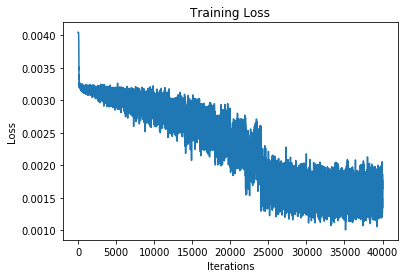

Final Training Accuracy: 69680/100000 (69.68%)
Final Training Loss: 0.31205


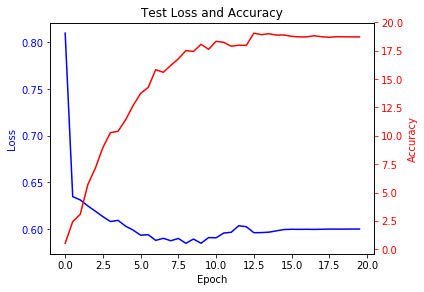

Final Test Accuracy: 1871/10000 (18.72%)
Final Test Loss: 0.59995


In [9]:
import matplotlib.pyplot as plt

plt.title('Training Loss')
plt.plot(TrainLoss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()
print 'Final Training Accuracy: %d/%d (%.2f%%)' % (TrN,TrD,ftrain_acc)
print 'Final Training Loss: %.5f' % (ftrain_loss)

statsIdx = range(len(TestAcc))
statsIdx = [float(c)/NUMSTATSPEREPOCH for c in statsIdx]

fig, ax1 = plt.subplots()
ax1.plot(statsIdx,TestLoss, 'b-')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(statsIdx,TestAcc, 'r-')
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params('y', colors='r')
fig.tight_layout()
plt.title('Test Loss and Accuracy')
plt.show()
print 'Final Test Accuracy: %d/%d (%.2f%%)' % (TN,TD,TestAcc[-1])
print 'Final Test Loss: %.5f' % (TestLoss[-1])